<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/master/kap9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kapitel 9: Deep Reinforcement Learning

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 12)
# mpl.rcParams["figure.dpi"] = 300

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
if 'google.colab' in sys.modules:
    !pip install -q tf-agents[reverb]==0.16.0 2>/dev/null
    !apt-get update >/dev/null
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 
# !pip install -q networkx==2.3.0 2>/dev/null
!pip install -q networkx 2>/dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 15.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 14.6 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [5]:
tf.random.set_seed(42)

In [6]:
import tensorflow_probability as tfp
tfp.__version__

'0.19.0'

In [7]:
import tf_agents
tf_agents.__version__

'0.16.0'

# Schritt I: Environment als OpenAI Gym Environment modellieren

In [8]:
import gym
from gym import spaces
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, clear_output
import networkx as nx
import numpy as np
import random
import urllib
import PIL

graph = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]

class OrsoEnv(gym.Env):
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        self.map = graph
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        self.reset()
        self.optimum = self.calculate_customers_reward()

        base = "https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/img/rl/graph/"
        self.image_orso = np.array(PIL.Image.open(urllib.request.urlopen(base + "Orso.png")))
        self.image_cave = np.array(PIL.Image.open(urllib.request.urlopen(base + "Cave.png")))
        self.image_honey = np.array(PIL.Image.open(urllib.request.urlopen(base + "Honey.png")))
        self.image_empty_pot = np.array(PIL.Image.open(urllib.request.urlopen(base + "EmptyPot.png")))
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        source = self.state

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": source, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    # each node gets a reward, either 0 or 10000
    def modulate_reward(self):
        self.customer_reward = {}

        node_names = list(self.map.keys())
        # initialize all nodes with 0
        for node_name in node_names:
            self.customer_reward[node_name] = 0

        # 10000 rewards are only at a few random places
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self._honeypot_places = []

        # starting from 1, not 0, so that 'S' (position of the cave) never gets a reward 
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        for sample in samples:
            self.customer_reward[node_names[sample]] = 1000
            self._honeypot_places = self._honeypot_places + [node_names[sample]]

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.customerReward = None
        self._honeypot_places = None
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for action, (target, cost) in enumerate(connections):
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                directed_label = str(source) + ":" + str(action)
                existing_edge = nx_graph.get_edge_data(source, target)
                if existing_edge is not None: 
                    directed_label = str(existing_edge['label']) + ' - ' + directed_label
                nx_graph.add_edge(source, target, color=color, weight=6, cost=cost, label=directed_label, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self, render_graph_labels=False, render_costs=False):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure()
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]

        nx.draw(self.nx_graph, pos=self.nx_pos, ax=ax, node_color='lightgrey',
                edges=edges, edge_color=edge_colors, width=edge_weights, with_labels=render_graph_labels)

        if render_graph_labels:
          edge_labels = [self.nx_graph[u][v]['label'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_labels))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        if render_costs:
          edge_costs = [self.nx_graph[u][v]['cost'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_costs))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.node[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            if node_id in self._honeypot_places:
                node['image'] = self.image_empty_pot
                if self.customer_reward[node_id] > 0:
                    node['image'] = self.image_honey
            else:
                node['image'] = None
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            node = self.nx_graph.node[n]
            image = node['image']
            if image is not None: 
                xp, yp = self.nx_pos[n]
                offset_image = OffsetImage(image, node['zoom'])
                offset_image.image.axes = ax
                ab = AnnotationBbox(offset_image, (xp, yp),
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.0,
                                    frameon=False
                                    )
                ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human', render_graph_labels=False, render_costs=False):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure(render_graph_labels=render_graph_labels, render_costs=render_costs)
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
          

# Schritt II: API des Environments verstehen

In [9]:
mpl.rcParams['figure.figsize'] = (20, 12)

In [10]:
env = OrsoEnv()
observation = env.reset()

# a flat vector consisting of
# 1. position of bear
# 1. 4 combined rewards (cost of travel plus potential honey reward) of the four paths the bear can choose
# 1. 14 values for each node, 1000 if there still is honey there, 0 otherwise
observation

array([    0.,   700.,  -100.,  -200., -1000.,     0.,  1000.,     0.,
           0.,  1000.,     0.,  1000.,     0.,  1000.,  1000.,  1000.,
           0.,     0.,     0.])

In [11]:
# env.render(render_graph_labels=True)

In [12]:
### after each step in a certain directon we get
# 1. the new observation
# 1. the reward for this step/action normalized to 1
# 1. if the game is done (bear needs to collect all honey and return to its cave)
# 1. additional information

observation, reward, done, info = env.step(1)
observation

array([   2., -100.,  900.,  -50.,  800.,    0., 1000.,    0.,    0.,
       1000.,    0., 1000.,    0., 1000., 1000., 1000.,    0.,    0.,
          0.])

In [13]:
reward, done, info

(-0.016666666666666666, False, {'from': 'S', 'to': 'B'})

In [15]:
# env.render(render_graph_labels=True)

## Environment registrieren

In [16]:
from tf_agents.environments import suite_gym, tf_py_environment

env_name="Orso-v1"

env = gym.envs.registration.register(id=env_name,entry_point=OrsoEnv, max_episode_steps=25)

# two envs for train and eval
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# converted to tf-agents tensorflow envs
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Schritt III: Für Phase 2 PPO konfigurieren

## Value Network


In [17]:
from tf_agents.networks import value_network, actor_distribution_network

value_net = value_network.ValueNetwork(
    train_env.observation_spec(), 
    fc_layer_params=(500, 500, 500),
    dropout_layer_params=(0.2, 0.2, 0.2))

In [18]:
time_step = train_env.reset()
observation = time_step.observation
value_net(observation)[0].numpy()

array([23.126644], dtype=float32)

## Policy Network

In [19]:
# data changes all the time, so risk to overfit is smaller than 
# in pure supervised training, but it might still bring a benefit and does not cost us much:
# https://openai.com/blog/quantifying-generalization-in-reinforcement-learning/
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(500, 500, 500),
    dropout_layer_params=(0.2, 0.2, 0.2))

In [20]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical
distribution, _ = actor_net(observation[0], time_step.step_type, ())
distribution.logits.numpy()

array([ -4.3570285, -20.633524 ,  -3.2150636,  38.048252 ], dtype=float32)

## Der PPO Agent nutzt beide Netzwerke

In [21]:
# https://github.com/tensorflow/agents/blob/master/tf_agents/agents/ppo/ppo_agent.py

from tf_agents.agents.ppo import ppo_agent

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # default is 1e-3

tf_ppo_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    use_gae=False, # just subtract value predictions from empirical return to calculate advantage
    entropy_regularization=0.01, # switched off by default, but we really want to boost initial exploration
    num_epochs=10) # 25 by default, but we see better results with more frequent updates of the training data
tf_ppo_agent.initialize()

# Schritt IV: Für Phase 2 Datensammeln konfigurieren

In [22]:
from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.utils import common

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ppo_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=10001)

avg_return = tf_metrics.AverageReturnMetric()
avg_length = tf_metrics.AverageEpisodeLengthMetric()

collect_driver = DynamicEpisodeDriver(train_env,
                                      tf_ppo_agent.collect_policy,
                                      observers=[replay_buffer.add_batch, avg_return, avg_length],
                                      num_episodes=10)
# just for optimized execution
tf_ppo_agent.train = common.function(tf_ppo_agent.train)
collect_driver.run = common.function(collect_driver.run)

# Schritt V: Trainings-Schleife

In [23]:
num_iterations =   500# @param {type:"integer"}
log_interval = 25 # @param {type:"integer"}

In [24]:
%%time

losses = []
policy_gradient_losses = []
value_estimation_losses = []
kl_losses = []
entropy_losses = []

returns = []
lengths = []

for iteration in range(num_iterations):
    
    # 1. collect data by playing
    collect_driver.run()
    trajectories = replay_buffer.gather_all()
    
    # 2. train with a new set of trajectories
    loss_info = tf_ppo_agent.train(trajectories)
    # 3. and clear afterwards
    replay_buffer.clear()

    # 4. just tracking of losses and other metrics
    total_loss = loss_info.loss.numpy()
    losses.append(total_loss)

    policy_gradient_loss = loss_info.extra.policy_gradient_loss.numpy()
    policy_gradient_losses.append(policy_gradient_loss)
    
    value_estimation_loss = loss_info.extra.value_estimation_loss.numpy()
    value_estimation_losses.append(value_estimation_loss)

    kl_loss = loss_info.extra.kl_penalty_loss.numpy()
    kl_losses.append(kl_loss)

    entropy_losses.append(loss_info.extra.entropy_regularization_loss.numpy())

    returns.append(avg_return.result().numpy())
    lengths.append(avg_length.result().numpy())    

    # logging
    step = tf_ppo_agent.train_step_counter.numpy()
    if step % log_interval == 0:
        print('iteration = {0} / step = {1}: loss = {2}, avg return = {3}, avg length = {4}'.format(
            iteration, step, total_loss, avg_return.result().numpy(), avg_length.result().numpy()))

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


iteration = 4 / step = 50: loss = 17.354116439819336, avg return = -1.1108332872390747, avg length = 25.0
iteration = 9 / step = 100: loss = 6.507023811340332, avg return = -0.6433333158493042, avg length = 25.0
iteration = 14 / step = 150: loss = 2.2450435161590576, avg return = -0.17250004410743713, avg length = 24.799999237060547
iteration = 19 / step = 200: loss = 2.2934350967407227, avg return = -0.153333380818367, avg length = 25.0
iteration = 24 / step = 250: loss = 2.300751209259033, avg return = -0.026666676625609398, avg length = 25.0
iteration = 29 / step = 300: loss = 3.2979536056518555, avg return = 0.044999975711107254, avg length = 25.0
iteration = 34 / step = 350: loss = 3.3103063106536865, avg return = 0.2149999588727951, avg length = 24.899999618530273
iteration = 39 / step = 400: loss = 2.1808226108551025, avg return = 0.29916661977767944, avg length = 24.100000381469727
iteration = 44 / step = 450: loss = 1.6403483152389526, avg return = 0.3633333146572113, avg leng

# Schritt VI: Losses und Metriken

In [25]:
mpl.rcParams['figure.figsize'] = (20, 12)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

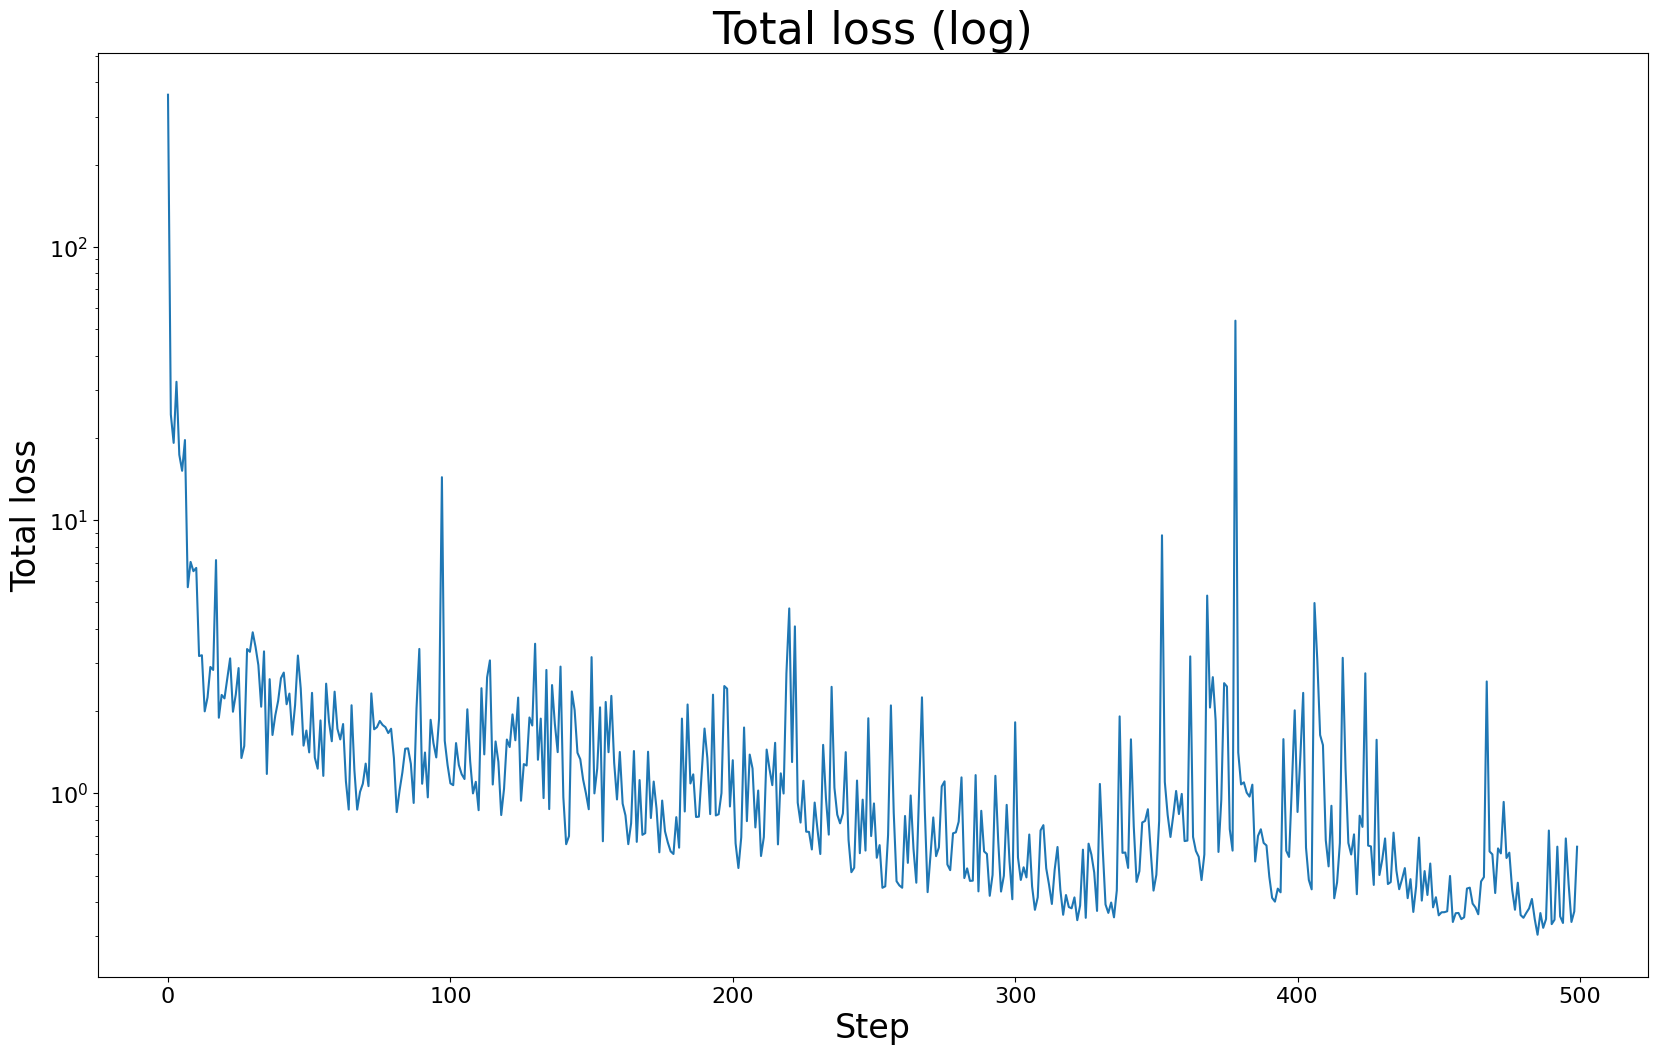

In [26]:
plt.yscale('log')
plt.plot(losses)
plt.title('Total loss (log)')
plt.ylabel('Total loss')
plt.xlabel('Step');

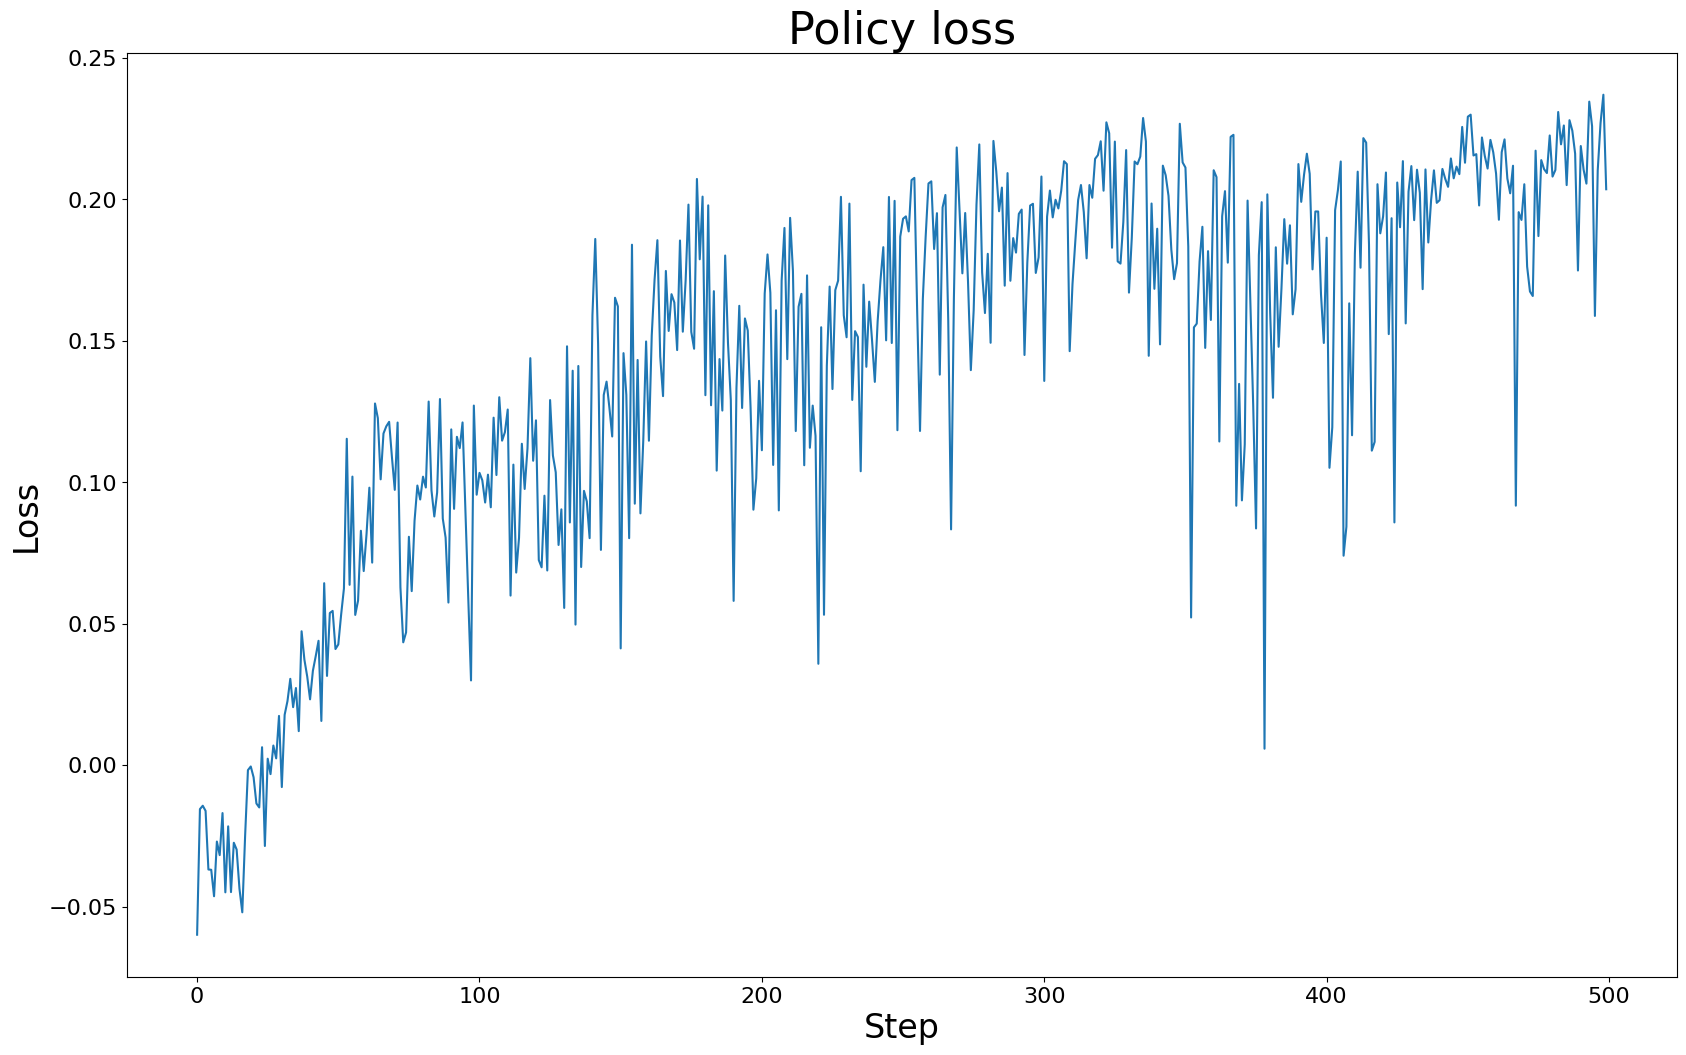

In [27]:
plt.plot(policy_gradient_losses)
plt.title('Policy loss')
plt.ylabel('Loss')
plt.xlabel('Step');
plt.savefig('actor-loss.png', transparent=True)

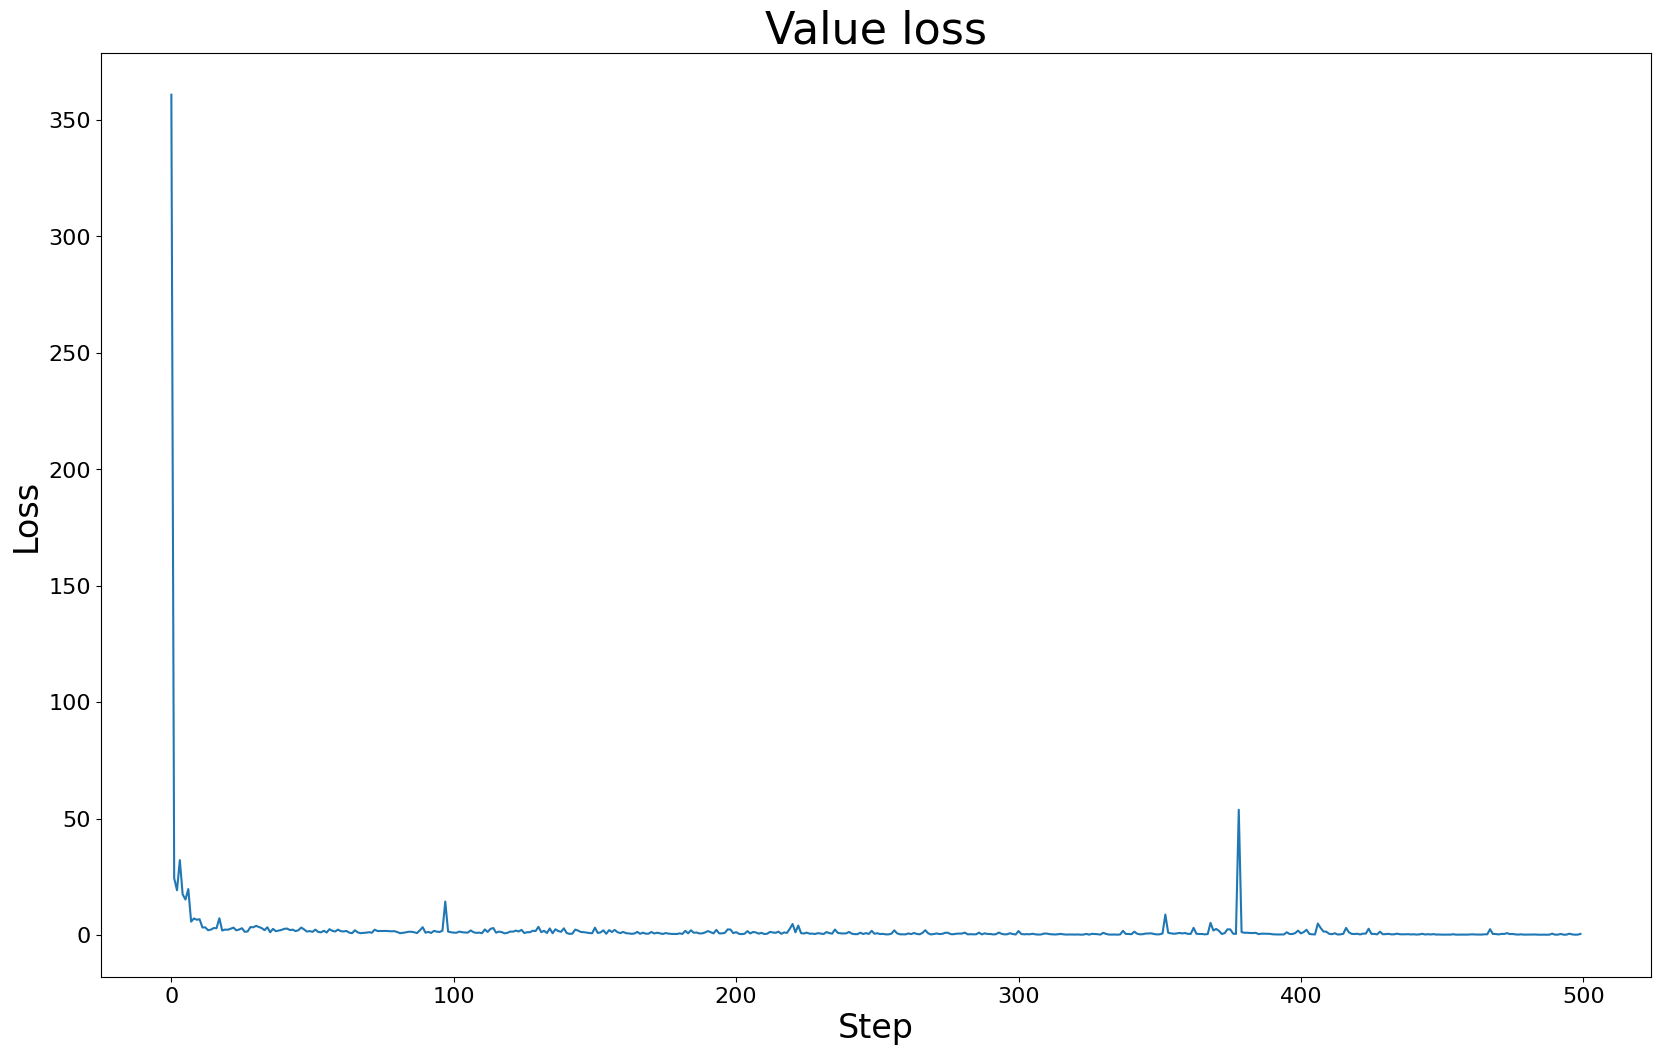

In [28]:
plt.plot(value_estimation_losses)
plt.title('Value loss')
plt.ylabel('Loss')
plt.xlabel('Step');
plt.savefig('value-loss.png', transparent=True);

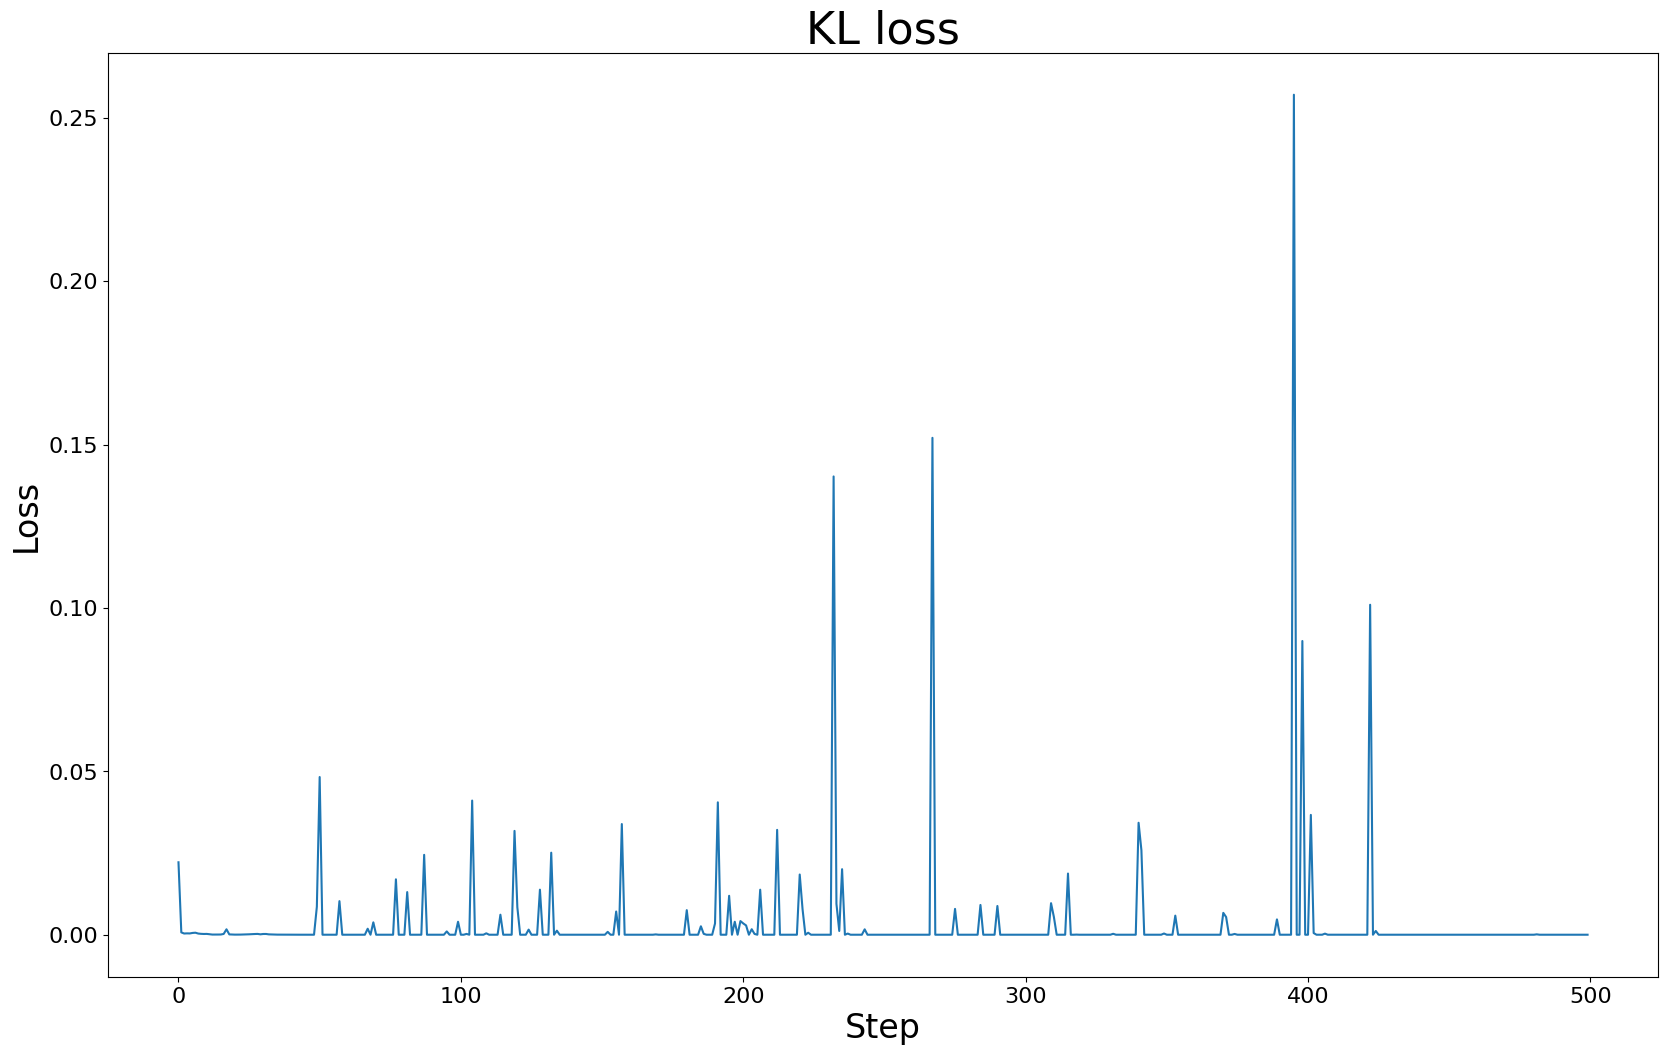

In [29]:
plt.plot(kl_losses)
plt.title('KL loss')
plt.ylabel('Loss')
plt.xlabel('Step');
plt.savefig('kl-loss.png', transparent=True);

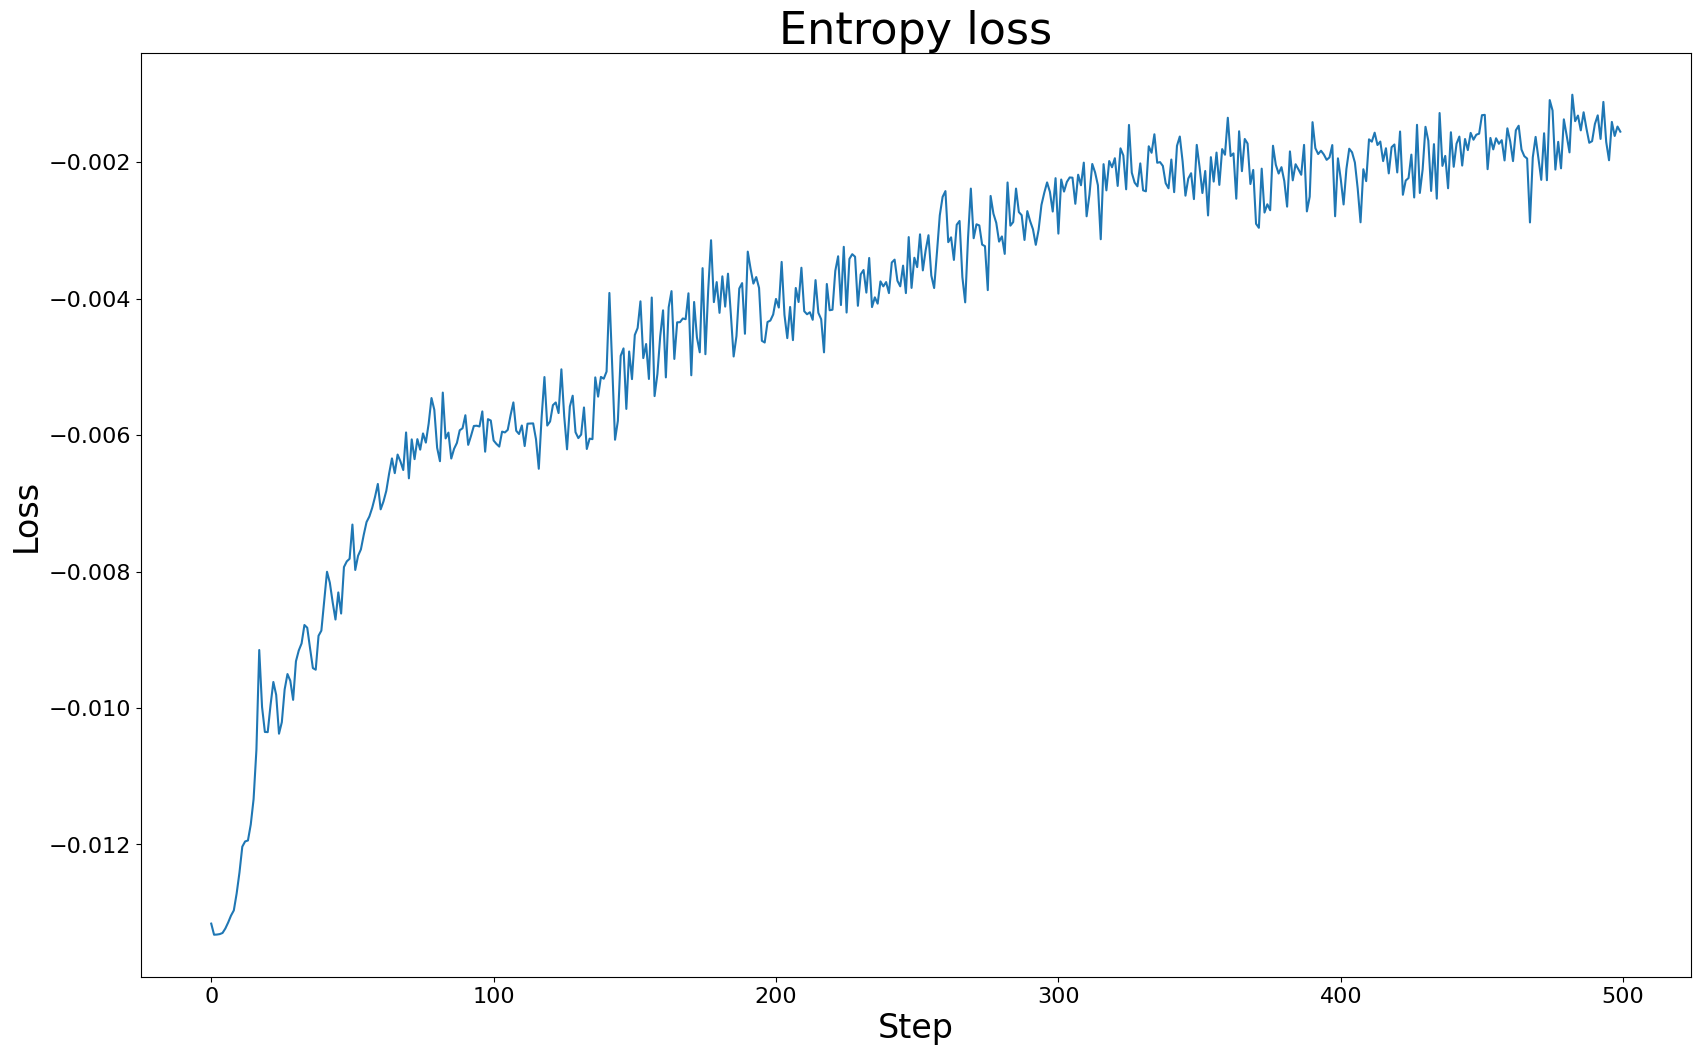

In [30]:
plt.plot(entropy_losses)
plt.title('Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Step');
plt.savefig('entropy-loss.png', transparent=True)

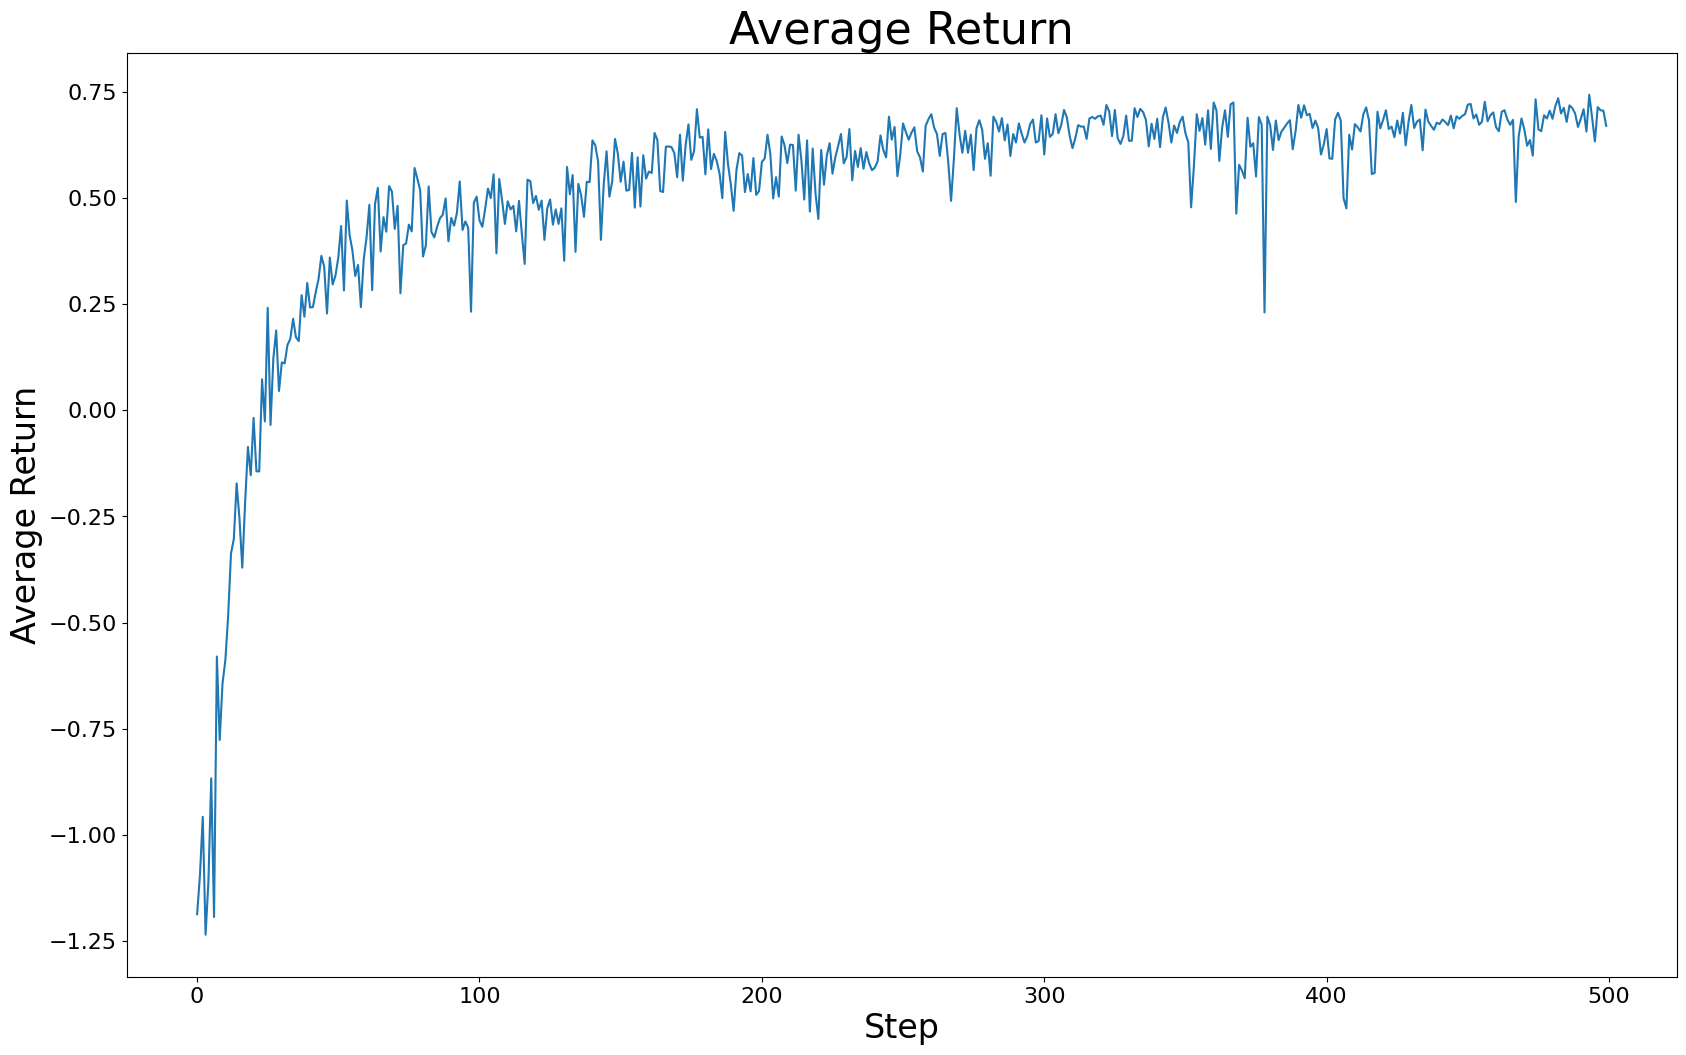

In [31]:
plt.plot(returns)
plt.title('Average Return')
plt.ylabel('Average Return')
plt.xlabel('Step');
plt.savefig('average-return.png', transparent=True);

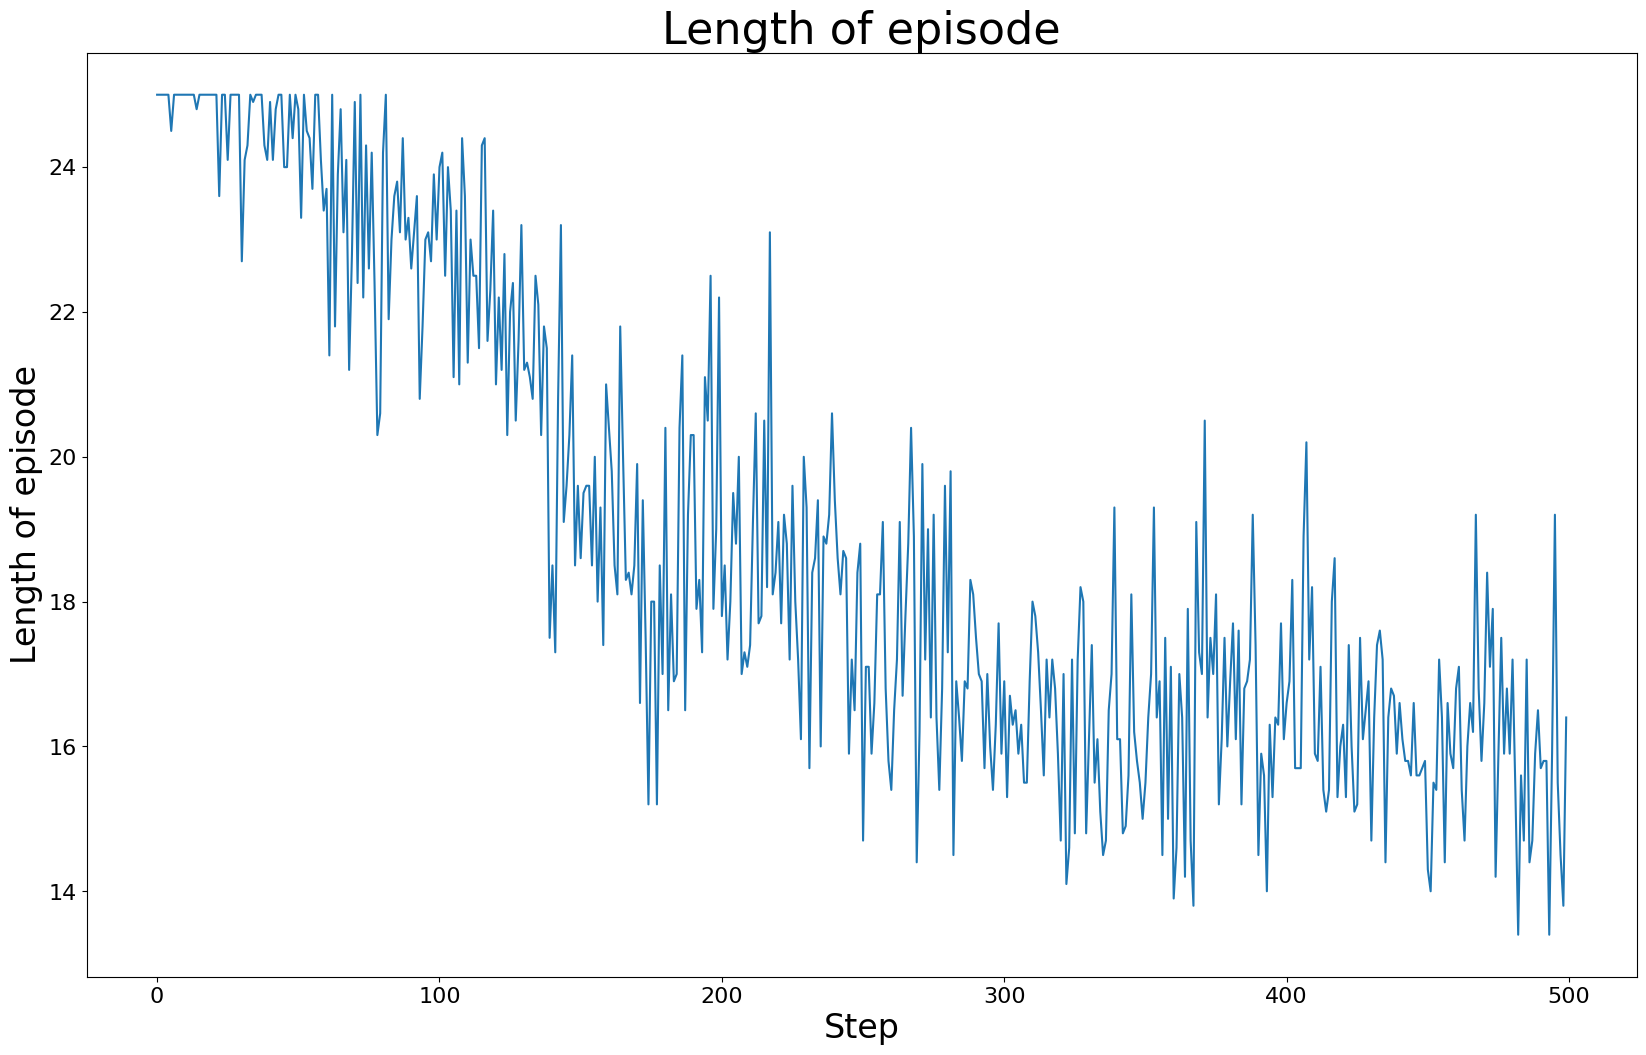

In [32]:
plt.plot(lengths)
plt.title('Length of episode')
plt.ylabel('Length of episode')
plt.xlabel('Step');
plt.savefig('average-length.png', transparent=True);

# Schritt VII: Am Ende interessiert nur noch die Policy

In [33]:
# https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial

import os
from tf_agents.policies import policy_saver

tf_policy_saver = policy_saver.PolicySaver(tf_ppo_agent.policy)
tf_policy_saver.save('policy')

In [34]:
!ls -l policy

total 188
drwxr-xr-x 2 root root   4096 May 30 08:51 assets
-rw-r--r-- 1 root root     56 May 30 08:51 fingerprint.pb
-rw-r--r-- 1 root root   3364 May 30 08:51 policy_specs.pbtxt
-rw-r--r-- 1 root root 172403 May 30 08:51 saved_model.pb
drwxr-xr-x 2 root root   4096 May 30 08:51 variables


In [35]:
saved_policy = tf.saved_model.load('policy')
saved_policy

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fb7468e6800>

In [36]:
time_step = eval_env.reset()
while not time_step.is_last():
  action_step = saved_policy.action(time_step)
  print(action_step.action.numpy()[0])  
  time_step = eval_env.step(action_step.action)

2
2
2
0
0
1
1
3
1
2
0
0
0
1
0


In [37]:
# import base64
# import imageio
# import IPython

# num_episodes = 1
# fps=2

# def embed_mp4(filename):
#   """Embeds an mp4 file in the notebook."""
#   video = open(filename,'rb').read()
#   b64 = base64.b64encode(video)
#   tag = '''
#   <video width="640" height="480" controls>
#     <source src="data:video/mp4;base64,{0}" type="video/mp4">
#   Your browser does not support the video tag.
#   </video>'''.format(b64.decode())

#   return IPython.display.HTML(tag)
# video_filename = 'imageio.mp4'
# with imageio.get_writer(video_filename, fps=fps) as video:
#   for _ in range(num_episodes):
#     time_step = eval_env.reset()
#     video.append_data(eval_py_env.render())
#     while not time_step.is_last():
#       action_step = saved_policy.action(time_step)
# #       print(action_step.action.numpy()[0])  
#       time_step = eval_env.step(action_step.action)
#       video.append_data(eval_py_env.render())

# embed_mp4(video_filename)